# Approaches to non-stationarity for multi-arm bandits

## Preliminaries

In [462]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math

## Bandit Environment

In [463]:
class NonStatGaussianBandits:

  """
    A class for Non-stationary Gaussian 3-armed bandits.

    Attributes
    ----------
    means : array of floats (size 3)
        the initial mean reward of each arm indexed from 0
    sigmas : array of floats
        the standard deviation of each arm indexed from 0
    freq : int
        the frequency at which the mean reward of the best and worst arms swap

    Methods
    -------
    sample(arm_index, t)
        Returns a reward sample of the arm indexed by arm_index at time t (implements non-stationarity by swapping
        the mean and variance of the best and worst arms whenever t % freq == 0)
  """

  def __init__(self, means, sigmas, freq):
      self.means =  means
      self.sigmas = sigmas
      self.freq = freq
      self.best_arm = np.argmax(means)
      self.worst_arm = np.argmin(means)

  def sample(self, arm_index, t):

    # swap the best and worst arms every freq time steps

    if (t + 1) % self.freq == 0: # assuming we start at t = 0
      tmp = self.means[self.best_arm]
      self.means[self.best_arm] = self.means[self.worst_arm] # swap means
      self.means[self.worst_arm] = tmp

      tmp = self.sigmas[self.best_arm]
      self.sigmas[self.best_arm] = self.sigmas[self.worst_arm] # swap stds
      self.sigmas[self.worst_arm] = tmp

      tmp = self.best_arm
      self.best_arm = self.worst_arm
      self.worst_arm = tmp

    # sample from arm indexed by arm_index

    return self.sigmas[arm_index] * np.random.rand() + self.means[arm_index]


(-15.0, 15.0)

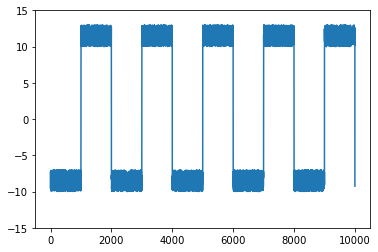

In [464]:
# example of how to sample
rewards = []
mybandit = NonStatGaussianBandits([-10, 0, 10], [3, 3, 3], 1000)
for t in range(10000):
  rewards.append(mybandit.sample(0, t))

plt.plot(range(10000), rewards)
plt.ylim([-15, 15])

In [500]:
Best_Algorithm = []
mybandit = NonStatGaussianBandits([-10, 0, 10], [5, 5, 5], 100)

## Epsilon-greedy Algorithm

In [466]:
def epsilon_greedy(bandit, epsilon, alpha = None, num_time_steps = 10000):
  """Epsilon greedy algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A non-stationary Gaussian bandit
  epsilon: float
      A parameter which determines the probability for a random action to be selected
  alpha: (optional) float
      A parameter which determines the learning rate for averaging. If alpha is None, incremental averaging is used.
      Default is None.
  num_time_step : int
      The number of time steps the algorithm should run for.

  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  """

  Q_arr = np.zeros(3) # array of estimated average reward for each action
  N_arr = np.zeros(3) # array of number of times picked for each action
  total_R = 0
  actions = range(3)

  R_over_t = []
  total_R_over_t = []

  for t in range(num_time_steps):
    A_best = np.random.choice(np.where(Q_arr == max(Q_arr))[0]) # get action with highest estimated average reward with random tie-breaking
    A_random = np.random.choice(actions)

    A = np.random.choice([A_best, A_random], p=[1 - epsilon, epsilon]) # pick a random action with probability epsilon
    curr_R = bandit.sample(A, t) # IMPORTANT THAT t IS INPUT HERE
    N_arr[A] = N_arr[A] + 1

    if alpha == None:
      # incremental averaging
      Q_arr[A] = Q_arr[A] + (1 / N_arr[A]) * (curr_R - Q_arr[A])
    else:
      Q_arr[A] = Q_arr[A] + alpha * (curr_R - Q_arr[A])

    R_over_t.append(curr_R)
    total_R = total_R + curr_R
    total_R_over_t.append(total_R)

  return R_over_t, total_R_over_t

### Graphs

0.005
0.01


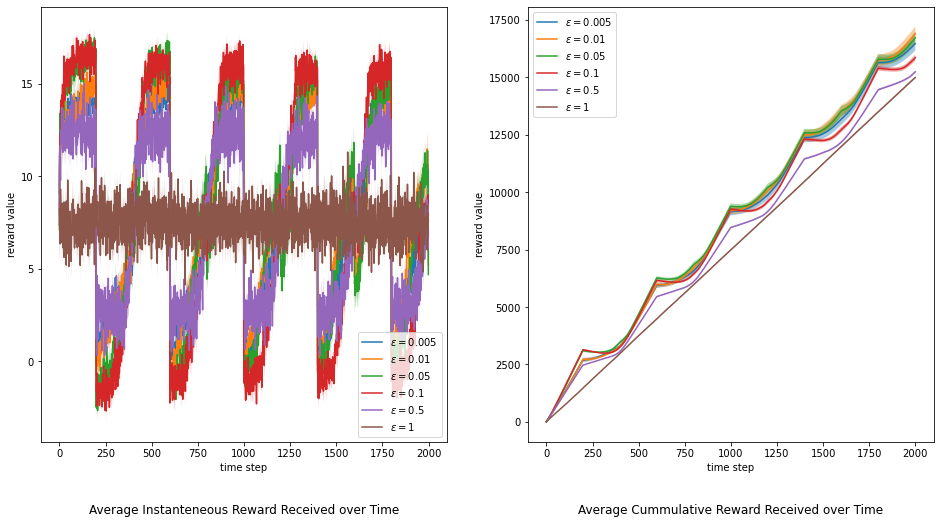

In [467]:
num_runs = 100
run_length = 2000
#mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 200)

epsilons = [0.005, 0.01, 0.05, 0.1, 0.5, 1]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
best_temp = 0
best_alg_temp = []

for epsilon in epsilons:

  # arrays of the data generated from num_runs runs
  R_over_t_runs = []
  total_R_over_t_runs = []

  for run in range(num_runs):
    R_over_t, total_R_over_t = epsilon_greedy(mybandit, epsilon, alpha=None, num_time_steps=run_length)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0].plot(mean_R_over_t_runs, label = r"$\epsilon = %s$" %epsilon)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0].fill_between(range(0,run_length), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)

  axs[0].legend()
  axs[0].set_xlabel("time step")
  axs[0].set_ylabel("reward value")
  axs[0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))
  if mean_total_R_over_t_runs[-1] > best_temp:
    best_alg_temp.append(mean_total_R_over_t_runs)
    print(epsilon)
    best_temp = mean_total_R_over_t_runs[-1]

  axs[1].plot(mean_total_R_over_t_runs, label = r"$\epsilon = %s$" %epsilon)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[1].fill_between(range(0,run_length), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[1].legend()
  axs[1].set_xlabel("time step")
  axs[1].set_ylabel("reward value")
  axs[1].set_title("Average Cummulative Reward Received over Time", y=-0.18)


#title = r'Graphs for Epsilon Greedy with Varying Epsilons'
#fig.suptitle(title, fontsize=16, y=0.08)
Best_Algorithm.append(best_alg_temp[-1])
plt.show()

In [468]:
print(len(Best_Algorithm))

1


## Thompson Sampling Algorithm

In [469]:
def Thompson_sampling(bandit, sig_prior, strength, num_time_steps = 10000):

    """Thompson Sampling Algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A non-stationary Gaussian bandit
  sig_prior : float
    the prior stanadard deviation we put for all the arms
  strength: int
    the strength of the prior corresponding to the number of times the each
    arm has a priori been sampled to obtain the current mean of 0
  num_time_steps : int
      The number of time steps the algorithm should run for.

  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  """


    N_arr = strength * np.ones(3) # array of number of times picked for each action
    total_R = 0
    actions = range(3)

    R_over_t = []
    total_R_over_t = []

    means = [0 for i in range(3)] # initally assume N(0, sig_prior) for each arm
    vars = [sig_prior for i in range(3)] # We do not update the variance

    for t in range(num_time_steps):
        thetas = []
        for arm in range(3):
            theta = vars[arm] * np.random.rand() + means[arm] # sample from Normal dist for each arm
            thetas.append(theta)
        A = np.argmax(thetas) # select arm based on highest sample

        curr_R = bandit.sample(A, t) # IMPORTANT THAT t IS INPUT HERE
        N_arr[A] += 1

        # update the distribution for the arm sampled

        n = N_arr[A]
        means[A] = means[A] * ((n-1)/ n) + curr_R / n
        #means[A] = means[A] * 0.75 + curr_R * 0.25

        R_over_t.append(curr_R)

        total_R = total_R + curr_R
        total_R_over_t.append(total_R)

    return R_over_t, total_R_over_t

### Graph

1
5
10
15
20


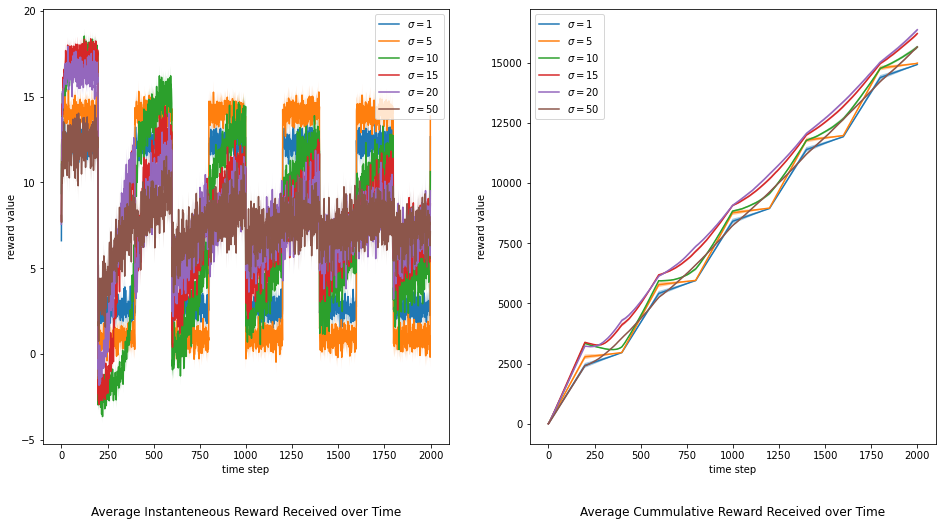

In [470]:
num_runs = 100
run_length = 2000
#mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 200)

strength = 1
prior_vars = [1, 5, 10, 15, 20, 50]
best_temp = 0
best_alg_temp = []

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for sig_prior in prior_vars:

  # arrays of the data generated from num_runs runs
  R_over_t_runs = []
  total_R_over_t_runs = []

  for run in range(num_runs):
    R_over_t, total_R_over_t = Thompson_sampling(mybandit, sig_prior, strength, num_time_steps=run_length)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0].plot(mean_R_over_t_runs, label = r"$\sigma = %s$" %sig_prior)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0].fill_between(range(0,2000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)

  axs[0].legend()
  axs[0].set_xlabel("time step")
  axs[0].set_ylabel("reward value")
  axs[0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))
  if mean_total_R_over_t_runs[-1] > best_temp:
    best_alg_temp.append(mean_total_R_over_t_runs)
    print(sig_prior)
    best_temp = mean_total_R_over_t_runs[-1]

  axs[1].plot(mean_total_R_over_t_runs, label = r"$\sigma = %s$" %sig_prior)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[1].fill_between(range(0,2000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[1].legend()
  axs[1].set_xlabel("time step")
  axs[1].set_ylabel("reward value")
  axs[1].set_title("Average Cummulative Reward Received over Time", y=-0.18)


#title = r'Graphs for Thompson sampling with various prior variances'
#fig.suptitle(title, fontsize=16, y=0.08)
Best_Algorithm.append(best_alg_temp[-1])
plt.show()

In [471]:
print(len(Best_Algorithm))

2


## EXP3

In [472]:
def EXP3(bandit, gamma, num_time_steps = 10000):

    """EXP3 Algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A non-stationary Gaussian bandit
  gamma : float in (0,1)
      Exploration paramter
  num_time_steps : int
      The number of time steps the algorithm should run for.

  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  """

    total_R = 0
    actions = range(3)

    R_over_t = []
    total_R_over_t = []

    W = [1 for i in range(3)] # initial weights for each arm

    for t in range(num_time_steps):

        Probs  = (1 - gamma) * (W / np.sum(W)) + gamma / 3 # array for the probability of selecting each arm
        Probs = Probs / np.sum(Probs)
        if np.isnan(Probs).any():
            W = np.ones(3)  # Reset weights in the case of NaN
            Probs = np.ones(3) / len(actions)  # Reset to uniform probabilities
        A = np.random.choice([0, 1, 2], p=Probs) # select an arm according to Probs

        curr_R = bandit.sample(A, t) # IMPORTANT THAT t IS INPUT HERE

        W[A] = W[A] * np.exp(gamma * curr_R / (Probs[A] * 3)) # update weight of selected arm

        R_over_t.append(curr_R)
        total_R = total_R + curr_R
        total_R_over_t.append(total_R)

    return R_over_t, total_R_over_t

### Graph

0.001
0.005
0.01


/var/folders/87/6s36_bp919z3s2zvqd35f8_80000gn/T/ipykernel_6386/857979311.py:41: RuntimeWarning: overflow encountered in scalar multiply
  W[A] = W[A] * np.exp(gamma * curr_R / (Probs[A] * 3)) # update weight of selected arm
/var/folders/87/6s36_bp919z3s2zvqd35f8_80000gn/T/ipykernel_6386/857979311.py:32: RuntimeWarning: invalid value encountered in divide
  Probs  = (1 - gamma) * (W / np.sum(W)) + gamma / 3 # array for the probability of selecting each arm


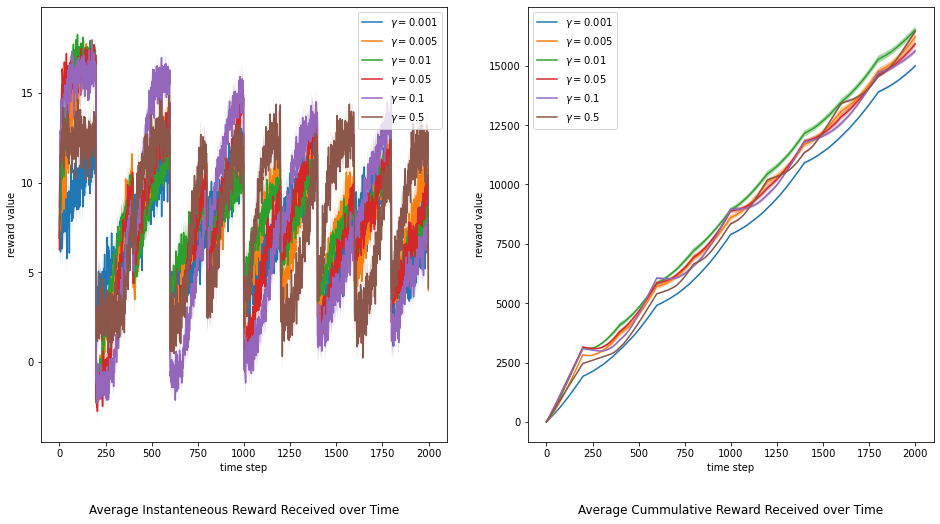

In [473]:
num_runs = 100
run_length = 2000
#mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 200)

gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
best_temp = 0
best_alg_temp = []

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for gamma in gammas:

  # arrays of the data generated from num_runs runs
  R_over_t_runs = []
  total_R_over_t_runs = []

  for run in range(num_runs):
    R_over_t, total_R_over_t = EXP3(mybandit, gamma, num_time_steps=run_length)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0].plot(mean_R_over_t_runs, label = r"$\gamma = %s$" %gamma)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0].fill_between(range(0,run_length), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)

  axs[0].legend()
  axs[0].set_xlabel("time step")
  axs[0].set_ylabel("reward value")
  axs[0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))
  if mean_total_R_over_t_runs[-1] > best_temp:
    best_alg_temp.append(mean_total_R_over_t_runs)
    print(gamma)
    best_temp = mean_total_R_over_t_runs[-1]

  axs[1].plot(mean_total_R_over_t_runs, label = r"$\gamma = %s$" %gamma)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[1].fill_between(range(0,run_length), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[1].legend()
  axs[1].set_xlabel("time step")
  axs[1].set_ylabel("reward value")
  axs[1].set_title("Average Cummulative Reward Received over Time", y=-0.18)


#title = r'Graphs for EXP3 with various prior variances'
#fig.suptitle(title, fontsize=16, y=0.08)

Best_Algorithm.append(best_alg_temp[-1])
plt.show()

In [474]:
print(len(Best_Algorithm))

3


## Discounted UCB

In [501]:
def Discounted_UCB(bandit, c, gamma, num_time_step=10000):
    """Discounted upper confidence bound algorithm for bandit action selection with non-stationary rewards.

    Parameters
    ----------
    bandit : NonStatGaussianBandits class
        A non-stationary Gaussian 3-armed bandit class with methods sample and attributes means, sigmas, freq.
    c : float
        A parameter which determines the degree of exploration.
    gamma : float
        Discount factor that reduces the weight of past observations.
    num_time_step : int
        The number of time steps to perform.

    Returns
    -------
    R_over_t : list
        A list of instantaneous return over the time steps.
    total_R_over_t : list
        A list of cumulative reward over the time steps.
    """
    num_arms = 3  # For a 3-armed bandit.
    Q_arr = np.zeros(num_arms)  # Estimated average reward for each action.
    N_arr = np.zeros(num_arms)  # Number of times each arm has been selected, with discounting.
    total_R = 0

    R_over_t = []
    total_R_over_t = []

    for t in range(num_time_step):
        ucb_values = np.zeros(num_arms)
        for arm in range(num_arms):
            bonus = c * np.sqrt(np.log(max(1, np.sum(N_arr))) / max(1, N_arr[arm]))
            ucb_values[arm] = Q_arr[arm] + bonus if N_arr[arm] > 0 else float('inf')

        A_t = np.argmax(ucb_values)  # Action chosen by UCB
        R_t = bandit.sample(A_t, t)

        # Apply discounting to all arm counts.
        N_arr *= gamma
        N_arr[A_t] += 1  # Increment the selected arm's count without discounting.

        # Update the estimated average reward for the selected arm.
        Q_arr[A_t] = (gamma * Q_arr[A_t] * (N_arr[A_t] - 1) + R_t) / N_arr[A_t]

        R_over_t.append(R_t)
        total_R += R_t
        total_R_over_t.append(total_R)

    return R_over_t, total_R_over_t

### Graph

0.3
0.5
0.7
0.99


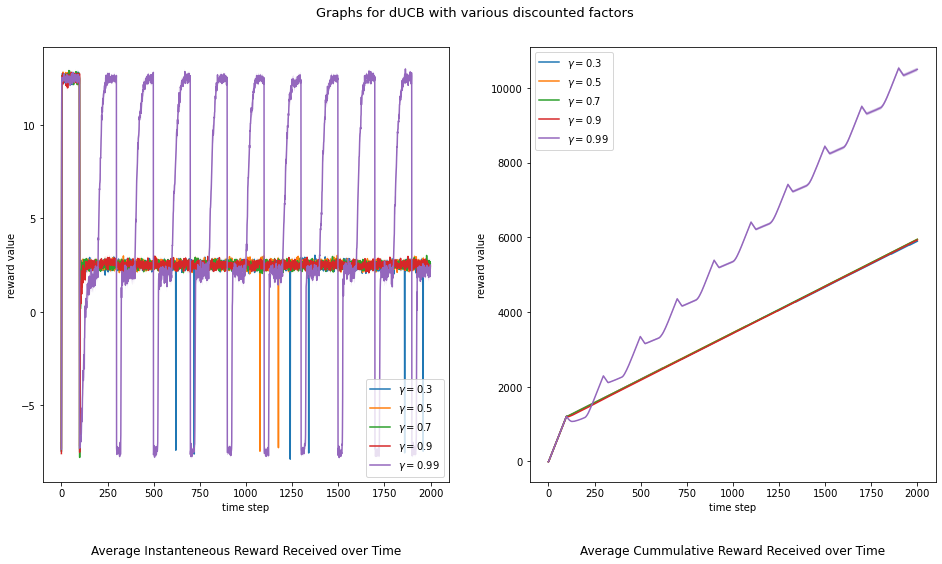

In [502]:
num_runs = 100
run_length = 2000

#mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 200) #100 and 200 frequency

gammas = [0.3, 0.5, 0.7, 0.9, 0.99]
c = 2
best_temp = 0
best_alg_temp = []

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for gamma in gammas:

  # arrays of the data generated from num_runs runs
  R_over_t_runs = []
  total_R_over_t_runs = []

  for run in range(num_runs):
    R_over_t, total_R_over_t = Discounted_UCB(mybandit, c, gamma, num_time_step=run_length)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0].plot(mean_R_over_t_runs, label = r"$\gamma = %s$" %gamma)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0].fill_between(range(0,run_length), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)

  axs[0].legend()
  axs[0].set_xlabel("time step")
  axs[0].set_ylabel("reward value")
  axs[0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))
  if mean_total_R_over_t_runs[-1] > best_temp:
    best_alg_temp.append(mean_total_R_over_t_runs)
    print(gamma)
    best_temp = mean_total_R_over_t_runs[-1]

  axs[1].plot(mean_total_R_over_t_runs, label = r"$\gamma = %s$" %gamma)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[1].fill_between(range(0,run_length), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[1].legend()
  axs[1].set_xlabel("time step")
  axs[1].set_ylabel("reward value")
  axs[1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

title = r'Graphs for dUCB with various discounted factors'
fig.suptitle(title, fontsize=13, y=0.95)

Best_Algorithm.append(best_alg_temp[-1])
plt.show()

In [489]:
print(len(Best_Algorithm))

1


## Sliding Window

In [503]:
def sliding_window_UCB(bandit, window_size, c, num_time_steps=10000):
    """Sliding Window UCB Algorithm for bandit action selection.

    Parameters
    ----------
    bandit : NonStatGaussianBandits
        A non-stationary Gaussian 3-armed bandit class with methods sample and attributes means, sigmas, freq.
    window_size : int
        Size of the sliding window for estimating average rewards.
    c : float
        A parameter which determines the degree of exploration.
    num_time_steps : int, optional
        The number of time steps the algorithm should run for, default is 10000.

    Returns
    -------
    R_over_t : list of floats
        A list of instantaneous returns over the time steps.
    total_R_over_t : list of floats
        A list of cumulative rewards over the time steps.
    """
    num_arms = 3  # For a 3-armed bandit.
    Q_arr = np.zeros(num_arms)  # Estimated average reward for each action.
    N_arr = np.zeros(num_arms)  # Number of times each arm has been selected.
    R_window = [[] for _ in range(num_arms)]  # Sliding window of rewards for each arm.

    total_R = 0
    R_over_t = []
    total_R_over_t = []

    for t in range(num_time_steps):
        ucb_values = np.zeros(num_arms)
        for arm in range(num_arms):
            if len(R_window[arm]) < window_size:
                Q_hat = np.mean(R_window[arm])
            else:
                Q_hat = np.mean(R_window[arm][-window_size:])  # Estimate using sliding window
            bonus = c * np.sqrt(np.log(max(1, np.sum(N_arr))) / max(1, N_arr[arm]))
            ucb_values[arm] = Q_hat + bonus

        A_t = np.argmax(ucb_values)  # Action chosen by UCB
        R_t = bandit.sample(A_t, t)

        # Update sliding window for the selected arm
        R_window[A_t].append(R_t)
        if len(R_window[A_t]) > window_size:
            R_window[A_t].pop(0)

        # Update the number of times the selected arm has been chosen
        N_arr[A_t] += 1

        # Update total reward
        total_R += R_t

        R_over_t.append(R_t)
        total_R_over_t.append(total_R)

    return R_over_t, total_R_over_t

### Graph

/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


100


/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


200


/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhaotongke/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: Runt

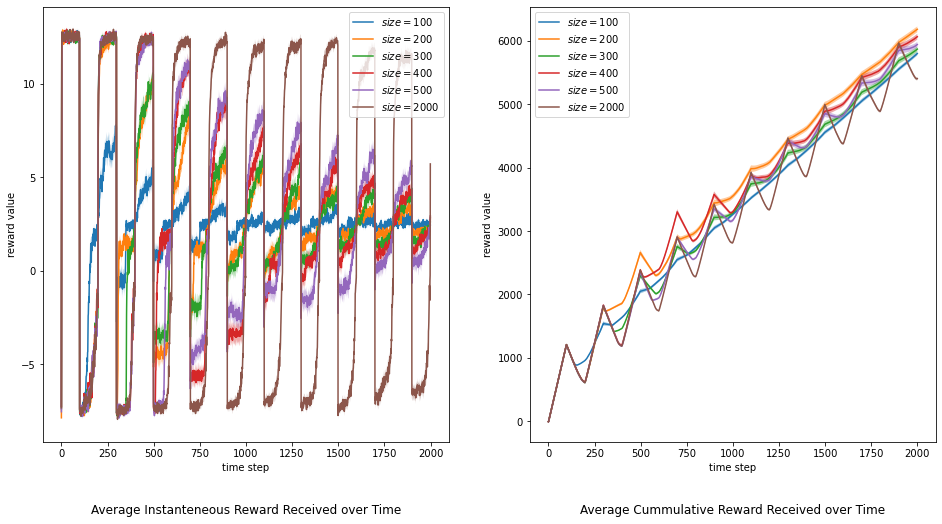

In [504]:
num_runs = 100
run_length = 2000

#mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 200) #c=20 is optimal
#mybandit = NonStatGaussianBandits([-5, 0, 5], [5, 5, 5], 200)
# mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 100)
# mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 200)

# Hyperparameters
window_sizes = [100, 200, 300, 400, 500, run_length]
c = 2
best_temp = 0
best_alg_temp = []

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for window_size in window_sizes:

  # arrays of the data generated from num_runs runs
  R_over_t_runs = []
  total_R_over_t_runs = []

  for run in range(num_runs):
    R_over_t, total_R_over_t = sliding_window_UCB(mybandit, window_size, c, num_time_steps=run_length)
    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0].plot(mean_R_over_t_runs, label = r"$size = %s$" %window_size)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0].fill_between(range(0,run_length), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)

  axs[0].legend()
  axs[0].set_xlabel("time step")
  axs[0].set_ylabel("reward value")
  axs[0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))
  if mean_total_R_over_t_runs[-1] > best_temp:
    best_alg_temp.append(mean_total_R_over_t_runs)
    print(window_size)
    best_temp = mean_total_R_over_t_runs[-1]

  axs[1].plot(mean_total_R_over_t_runs, label = r"$size = %s$" %window_size)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[1].fill_between(range(0,run_length), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[1].legend()
  axs[1].set_xlabel("time step")
  axs[1].set_ylabel("reward value")
  axs[1].set_title("Average Cummulative Reward Received over Time", y=-0.18)


#title = r'Graphs for dUCB with various discounted factors'
#fig.suptitle(title, fontsize=16, y=0.08)
Best_Algorithm.append(best_alg_temp[-1])
plt.show()

In [480]:
print(len(Best_Algorithm))

5


## Bayes UCB

In [505]:
def bayes_UCB(bandit, c, reward_obj = None, burn_in = 0, num_time_steps=10000):
    """Bayes UCB Algorithm for bandit action selection.

    Parameters
    ----------
    bandit : NonStatGaussianBandits
        A non-stationary Gaussian 3-armed bandit class with methods sample and attributes means, sigmas, freq.
    c : float
        A parameter which determines the degree of exploration.
    reward_obj : int
        The reward object that is used to update the posterior distribution.
    burn_in : float
        Number of initial observations per arm before using the posterior distribution.
    num_time_steps : int, optional
        The number of time steps the algorithm should run for, default is 10000.

    Returns
    -------
    R_over_t : list of floats
        A list of instantaneous returns over the time steps.
    total_R_over_t : list of floats
        A list of cumulative rewards over the time steps.
    """

    # Initialize variables
    K = len(bandit.means)
    n = np.zeros(K)
    S = np.zeros(K)
    R_over_t = []
    total_R_over_t = []
    arm_rewards = [[] for _ in range(K)]

    # Initial exploration
    for t in range(burn_in):
        arm = t % K
        reward = bandit.sample(arm)
        arm_rewards[arm].append(reward)
        n[arm] += 1
        S[arm] += reward

    # Main loop
    for t in range(burn_in, num_time_steps):
        # Compute UCB for each arm
        UCB = [S[a] / n[a] + c * np.sqrt(2 * np.log(t+1) / n[a]) for a in range(K)]

        # Select arm with maximum UCB
        arm = np.argmax(UCB)

        # Sample from the chosen arm
        reward = bandit.sample(arm, t)
        arm_rewards[arm].append(reward)
        n[arm] += 1
        S[arm] += reward

        # Compute instantaneous return
        R_over_t.append(reward)

        # Compute total cumulative reward
        total_R_over_t.append(sum(R_over_t))

    return R_over_t, total_R_over_t

### Graph

/var/folders/87/6s36_bp919z3s2zvqd35f8_80000gn/T/ipykernel_6386/279197110.py:44: RuntimeWarning: invalid value encountered in scalar divide
  UCB = [S[a] / n[a] + c * np.sqrt(2 * np.log(t+1) / n[a]) for a in range(K)]
/var/folders/87/6s36_bp919z3s2zvqd35f8_80000gn/T/ipykernel_6386/279197110.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  UCB = [S[a] / n[a] + c * np.sqrt(2 * np.log(t+1) / n[a]) for a in range(K)]


100


/var/folders/87/6s36_bp919z3s2zvqd35f8_80000gn/T/ipykernel_6386/279197110.py:44: RuntimeWarning: invalid value encountered in scalar divide
  UCB = [S[a] / n[a] + c * np.sqrt(2 * np.log(t+1) / n[a]) for a in range(K)]
/var/folders/87/6s36_bp919z3s2zvqd35f8_80000gn/T/ipykernel_6386/279197110.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  UCB = [S[a] / n[a] + c * np.sqrt(2 * np.log(t+1) / n[a]) for a in range(K)]
/var/folders/87/6s36_bp919z3s2zvqd35f8_80000gn/T/ipykernel_6386/279197110.py:44: RuntimeWarning: invalid value encountered in scalar divide
  UCB = [S[a] / n[a] + c * np.sqrt(2 * np.log(t+1) / n[a]) for a in range(K)]
/var/folders/87/6s36_bp919z3s2zvqd35f8_80000gn/T/ipykernel_6386/279197110.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  UCB = [S[a] / n[a] + c * np.sqrt(2 * np.log(t+1) / n[a]) for a in range(K)]
/var/folders/87/6s36_bp919z3s2zvqd35f8_80000gn/T/ipykernel_6386/279197110.py:44: RuntimeWarning: invalid value encountered in 

600


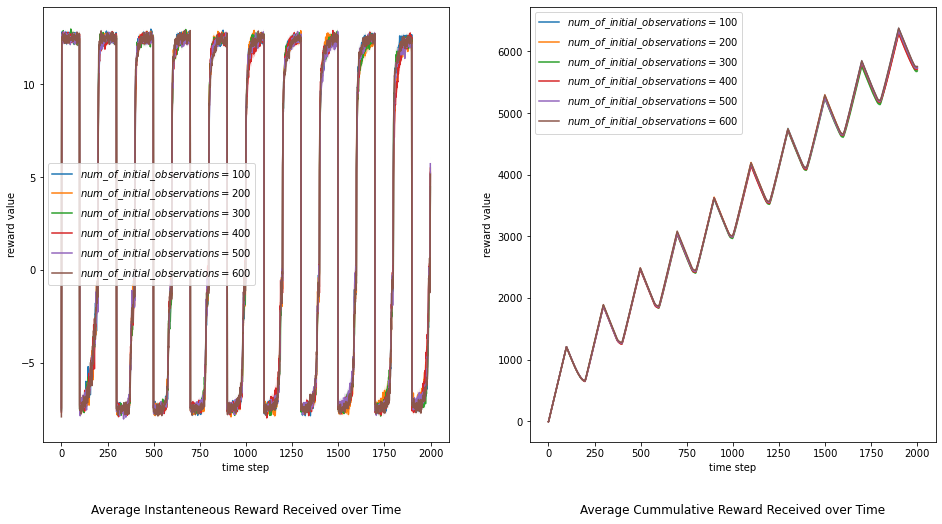

In [506]:
num_runs = 100
run_length = 2000

# mybandit = NonStatGaussianBandits([-5, 0, 5], [5, 5, 5], 100)
#mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 200)
# mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 100)
# mybandit = NonStatGaussianBandits([-10, 0, 10], [15, 15, 15], 200)

# Hyperparameters
c = 2
burn_in = [100, 200, 300, 400, 500, 600]
best_temp = 0
best_alg_temp = []

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for num_initial_obs in burn_in:

  # arrays of the data generated from num_runs runs
  R_over_t_runs = []
  total_R_over_t_runs = []

  for run in range(num_runs):
    R_over_t, total_R_over_t = bayes_UCB(mybandit, c, num_time_steps=run_length)
    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0].plot(mean_R_over_t_runs, label = r"$num\_of\_initial\_observations = %s$" %num_initial_obs)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0].fill_between(range(0,run_length), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)

  axs[0].legend()
  axs[0].set_xlabel("time step")
  axs[0].set_ylabel("reward value")
  axs[0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

  axs[1].plot(mean_total_R_over_t_runs, label = r"$num\_of\_initial\_observations = %s$" %num_initial_obs)
  if mean_total_R_over_t_runs[-1] > best_temp:
    best_alg_temp.append(mean_total_R_over_t_runs)
    print(num_initial_obs)
    best_temp = mean_total_R_over_t_runs[-1]

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[1].fill_between(range(0,run_length), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[1].legend()
  axs[1].set_xlabel("time step")
  axs[1].set_ylabel("reward value")
  axs[1].set_title("Average Cummulative Reward Received over Time", y=-0.18)


#title = r'Graphs for dUCB with various discounted factors'
#fig.suptitle(title, fontsize=16, y=0.08)
Best_Algorithm.append(best_alg_temp[-1])
plt.show()

In [483]:
print(len(Best_Algorithm))

6


## Plot for best performance

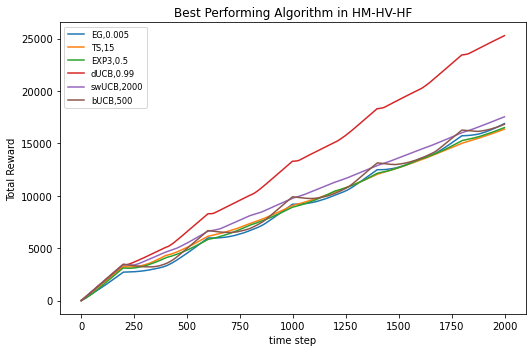

In [485]:
parameters = [0.005, 15, 0.5, 0.99, 2000, 500]

algorithm_labels = [
    "EG,{}",
    "TS,{}",
    "EXP3,{}",
    "dUCB,{}",
    "swUCB,{}",
    "bUCB,{}"
]

plt.figure(figsize=(10, 5))

# Plot the results for each algorithm
for results, label, param in zip(Best_Algorithm, algorithm_labels, parameters):
    plt.plot(results, label=label.format(param))

# Set up the plot with titles and labels
plt.xlabel('time step')
plt.ylabel('Total Reward')
#plt.title('Best Performing Algorithm in LM-LV-LF')
plt.title('Best Performing Algorithm in HM-HV-HF')
# plt.title('Best Performing Algorithm in LM-HV-LF')
# plt.title('Best Performing Algorithm in LM-HV-LF')
# plt.title('Best Performing Algorithm in LM-HV-LF')
# plt.title('Best Performing Algorithm in LM-HV-LF')
# plt.title('Best Performing Algorithm in LM-HV-LF')
# plt.title('Best Performing Algorithm in LM-HV-LF')

# Set the legend to be small and placed outside the plot to avoid blocking the view
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.legend(loc='upper left', fontsize='small')

# Tight layout to adjust for the external legend
plt.tight_layout(rect=[0, 0, 0.75, 1])

plt.show()
